In [34]:
%store -r df
%store -r custom_palette
%store -r rslt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.metrics import accuracy_score

In [35]:
# outlier detection
def detect_outliers(df,n,features):
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index 
        outlier_indices.extend(outlier_list_col)
    
    outlier_indices = Counter(outlier_indices)  
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return(multiple_outliers)

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [36]:
drop_outliers = detect_outliers(df,1,
                                ["age","hours_studied"])
df.loc[drop_outliers]
df = df.drop(drop_outliers, axis = 0).reset_index(drop=True)

In [37]:
# Fill empty and NaNs values with NaN
dataset = df.fillna(np.nan)
dataset.isnull().sum()

sex                     0
lang                    0
country                 0
age                     0
hours_studied           0
class                   0
test_prep               0
pass                    0
notes                   0
goals/hopes/concerns    0
class2                  0
continent               0
english                 0
age_bin                 0
hour_bin                0
notes_js                0
goals_english           0
goals_learn             0
dtype: int64

In [38]:
dataset.describe()

,age,hours_studied,notes_js,goals_english,goals_learn
count,4996.000000,4996.000000,4996.000000,4996.000000,4996.000000
mean,25.856085,2.987194,0.059047,0.004003,0.002802
std,7.327236,3.463273,0.235737,0.063150,0.052867
min,18.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000
50%,24.000000,2.129121,0.000000,0.000000,0.000000
75%,30.000000,4.886971,0.000000,0.000000,0.000000
max,50.000000,24.259314,1.000000,1.000000,1.000000


/Users/jaichung/Documents/10_Work/woven/venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jaichung/Documents/10_Work/woven/venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


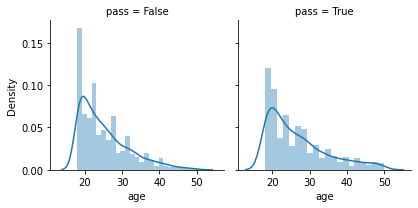

In [39]:
# age vs pass
fig = sns.FacetGrid(dataset, col='pass')
fig.map(sns.distplot, "age")

Text(0, 0.5, 'Number of students')

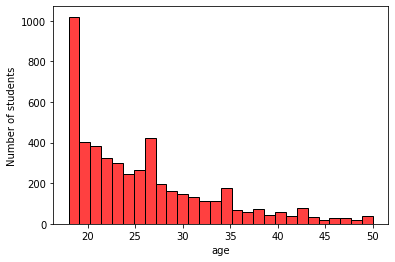

In [40]:
# Age distribution
fig = sns.histplot(dataset["age"], color="Red")
fig.set_xlabel("age")
fig.set_ylabel("Number of students")


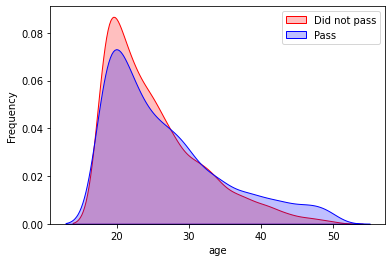

In [41]:
# Explore Age distibution by pass/fail
fig = sns.kdeplot(dataset["age"][(dataset["pass"] == False) & (dataset["age"].notnull())], color="Red", shade = True)
fig = sns.kdeplot(dataset["age"][(dataset["pass"] == True) & (dataset["age"].notnull())], color="Blue", shade= True)
fig.set_xlabel("age")
fig.set_ylabel("Frequency")
fig = fig.legend(["Did not pass","Pass"])


/Users/jaichung/Documents/10_Work/woven/venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


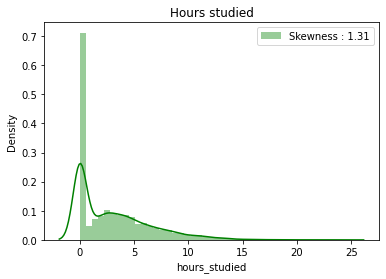

In [42]:
# hours studied
fig = sns.distplot(dataset["hours_studied"], color="g", 
                 label="Skewness : %.2f"%(dataset["hours_studied"].skew()))
fig.set_title("Hours studied")
fig.legend(loc="best")

In [43]:
# Apply log to Fare to reduce skewness distribution
dataset["hours_studied"] = dataset["hours_studied"].map(lambda i: np.log(i+1))

/Users/jaichung/Documents/10_Work/woven/venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


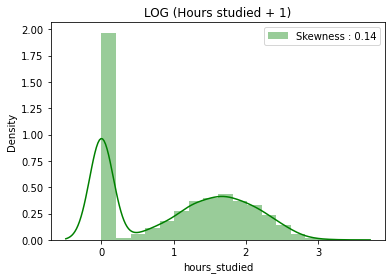

In [44]:
# hours studied
fig = sns.distplot(dataset["hours_studied"], color="g", 
                 label="Skewness : %.2f"%(dataset["hours_studied"].skew()))
fig.set_title("LOG (Hours studied + 1)")
fig.legend(loc="best")

,pass
sex,
Female,0.283594
Male,0.529871


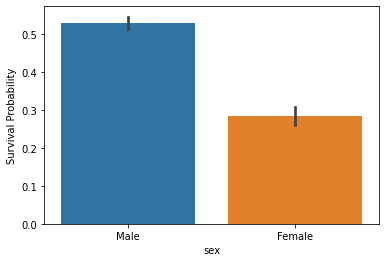

In [45]:
# sex
fig = sns.barplot(x="sex",y="pass",data=dataset)
fig.set_ylabel("Survival Probability")
dataset[["sex","pass"]].groupby('sex').mean()

/Users/jaichung/Documents/10_Work/woven/venv/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/jaichung/Documents/10_Work/woven/venv/lib/python3.9/site-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


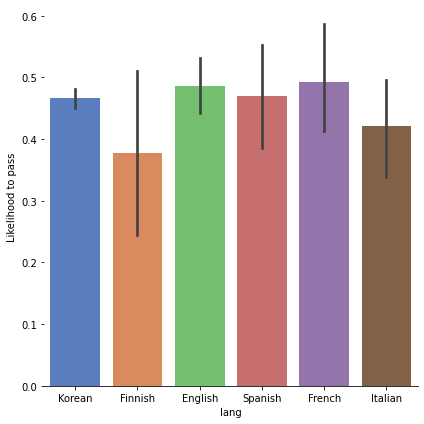

In [46]:
# explore language
fig = sns.factorplot(x="lang",y="pass", data=dataset,
kind="bar", size = 6 , 
palette = "muted")
fig.despine(left=True)
fig.set_ylabels("Likelihood to pass")

/Users/jaichung/Documents/10_Work/woven/venv/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/jaichung/Documents/10_Work/woven/venv/lib/python3.9/site-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


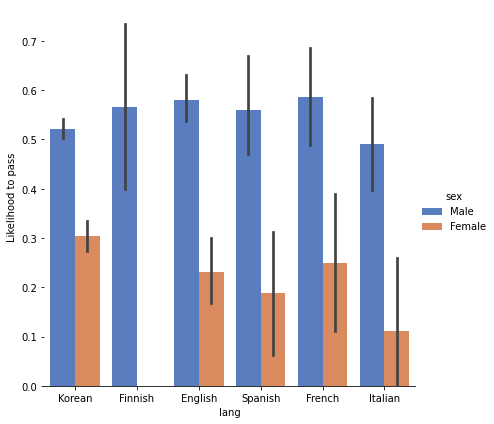

In [47]:
# Explore language vs pass by sex
fig = sns.factorplot(x="lang", y="pass", hue="sex", data=dataset,
                   size=6, kind="bar", palette="muted")
fig.despine(left=True)
fig.set_ylabels("Likelihood to pass")

/Users/jaichung/Documents/10_Work/woven/venv/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/jaichung/Documents/10_Work/woven/venv/lib/python3.9/site-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/jaichung/Documents/10_Work/woven/venv/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/jaichung/Documents/10_Work/woven/ven

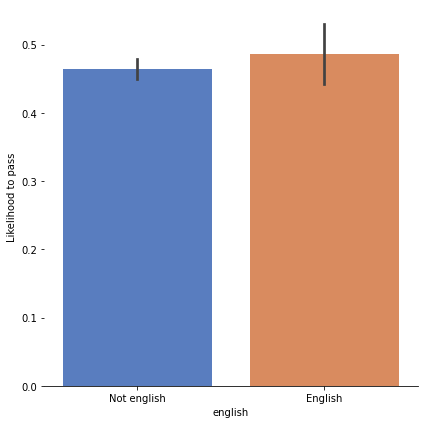

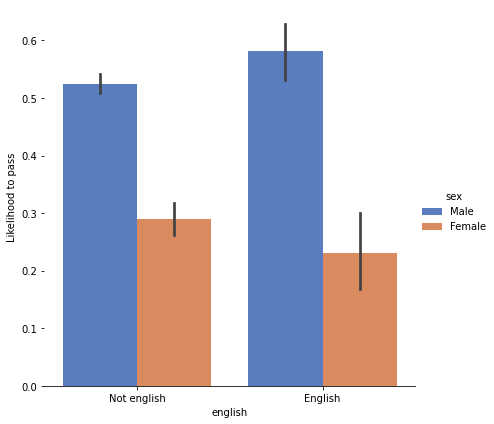

In [48]:
# explore by english
fig = sns.factorplot(x="english",y="pass", data=dataset,
kind="bar", size = 6 , 
palette = "muted")
fig.despine(left=True)
fig.set_ylabels("Likelihood to pass")
fig = sns.factorplot(x="english", y="pass", hue="sex", data=dataset,
                   size=6, kind="bar", palette="muted")
fig.despine(left=True)
fig.set_ylabels("Likelihood to pass")

/Users/jaichung/Documents/10_Work/woven/venv/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/jaichung/Documents/10_Work/woven/venv/lib/python3.9/site-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/jaichung/Documents/10_Work/woven/venv/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/jaichung/Documents/10_Work/woven/ven

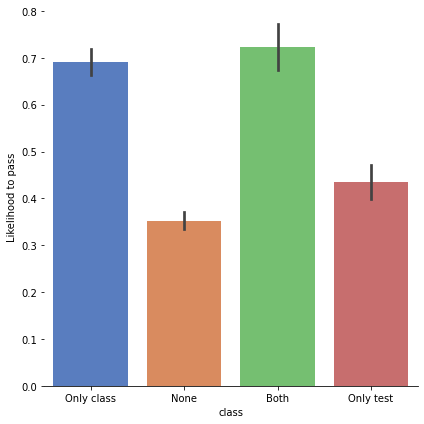

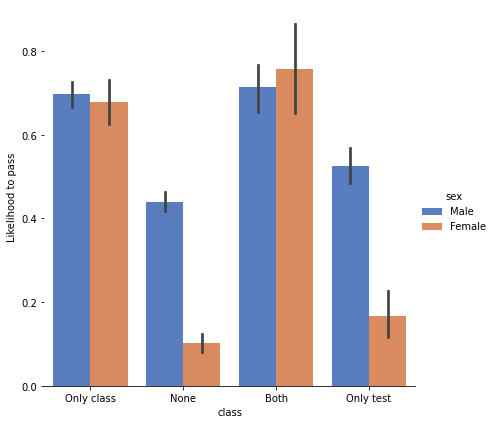

In [49]:
# explore by 
fig = sns.factorplot(x="class",y="pass", data=dataset,
kind="bar", size = 6 , 
palette = "muted")
fig.despine(left=True)
fig.set_ylabels("Likelihood to pass")
fig = sns.factorplot(x="class", y="pass", hue="sex", data=dataset,
                   size=6, kind="bar", palette="muted")
fig.despine(left=True)
fig.set_ylabels("Likelihood to pass")

/Users/jaichung/Documents/10_Work/woven/venv/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/jaichung/Documents/10_Work/woven/venv/lib/python3.9/site-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/jaichung/Documents/10_Work/woven/venv/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/jaichung/Documents/10_Work/woven/ven

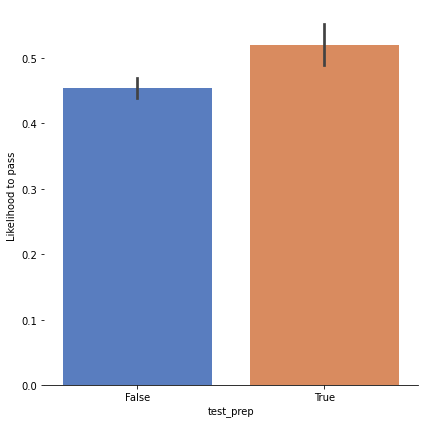

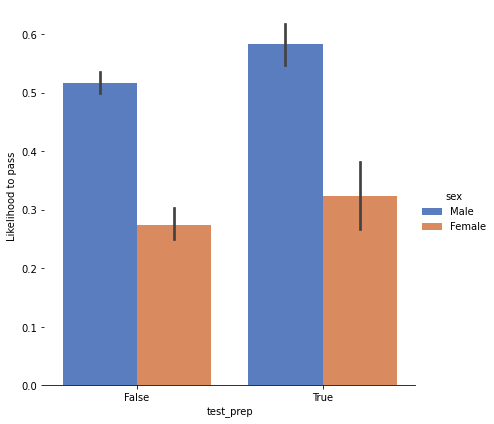

In [50]:
# explore by test prep
fig = sns.factorplot(x="test_prep",y="pass", data=dataset,
kind="bar", size = 6 , 
palette = "muted")
fig.despine(left=True)
fig.set_ylabels("Likelihood to pass")
fig = sns.factorplot(x="test_prep", y="pass", hue="sex", data=dataset,
                   size=6, kind="bar", palette="muted")
fig.despine(left=True)
fig.set_ylabels("Likelihood to pass")

/Users/jaichung/Documents/10_Work/woven/venv/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/jaichung/Documents/10_Work/woven/venv/lib/python3.9/site-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/jaichung/Documents/10_Work/woven/venv/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/jaichung/Documents/10_Work/woven/ven

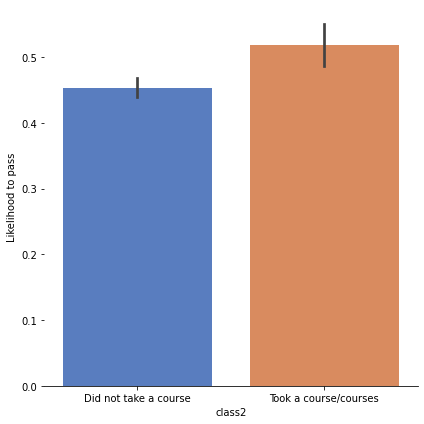

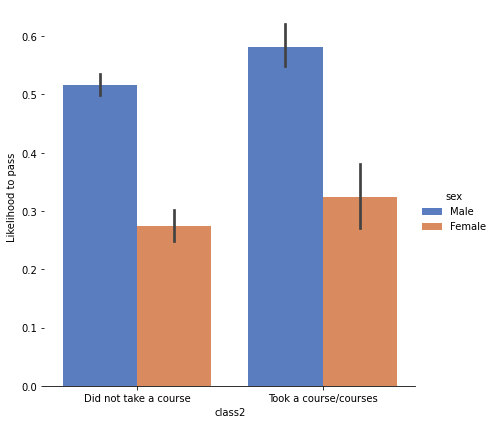

In [51]:
# explore by if student had taken at least one course
fig = sns.factorplot(x="class2",y="pass", data=dataset,
kind="bar", size = 6 , 
palette = "muted")
fig.despine(left=True)
fig.set_ylabels("Likelihood to pass")
fig = sns.factorplot(x="class2", y="pass", hue="sex", data=dataset,
                   size=6, kind="bar", palette="muted")
fig.despine(left=True)
fig.set_ylabels("Likelihood to pass")

In [52]:
## feature engineering
# english as mother tongue
dataset = pd.get_dummies(dataset, columns = ["english"],prefix="fl")

# class
dataset = pd.get_dummies(dataset, columns = ["class"],prefix="class")

# testprep
dataset = pd.get_dummies(dataset, columns = ["test_prep"],prefix="tp")

# country
dataset = pd.get_dummies(dataset, columns = ["country"],prefix="nat")

In [53]:
# drop other variables
data_f = dataset._get_numeric_data()

In [54]:
# stratified sampling
x_train, x_valid, y_train, y_valid = train_test_split(data_f, data_f['pass'], test_size=0.2, shuffle=True, 
                                                      stratify=data_f['pass'], random_state=34)
x_train = x_train.drop(labels = ["pass"],axis = 1)
test = x_valid.drop('pass', axis = 1)
test_ind = test.index

In [55]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

In [56]:
# Modeling step testing different algorithms 
random_state = 2
cfs = []
cfs.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
cfs.append(DecisionTreeClassifier(random_state=random_state))
cfs.append(RandomForestClassifier(random_state=random_state))
cfs.append(ExtraTreesClassifier(random_state=random_state))
cfs.append(KNeighborsClassifier())
cfs.append(LogisticRegression(random_state = random_state))
cfs.append(LinearDiscriminantAnalysis())
cfs.append(GradientBoostingClassifier(random_state=random_state))

/Users/jaichung/Documents/10_Work/woven/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jaichung/Documents/10_Work/woven/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Text(0.5, 1.0, 'Cross validation scores')

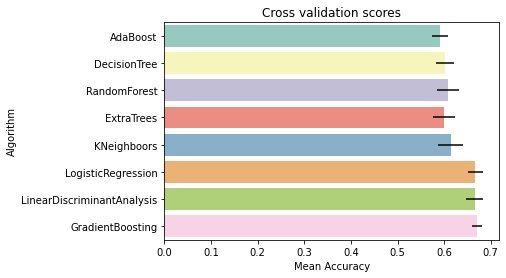

In [57]:
cv_results = []
for cf in cfs :
    cv_results.append(cross_val_score(cf, x_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["AdaBoost","DecisionTree",
"RandomForest","ExtraTrees","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis","GradientBoosting"]})

fig = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
fig.set_xlabel("Mean Accuracy")
fig.set_title("Cross validation scores")

Gradient boosting, Logistic Regression, Linear Discriminant Analysis are the highest - these will be considered for ensemble modeling.

In [58]:
# gradient boosting

gbc = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsgbc = GridSearchCV(gbc,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsgbc.fit(x_train,y_train)

gbc_best = gsgbc.best_estimator_

# Best score
gsgbc.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.6751704260651629

In [59]:
# logistic regression
lr = LogisticRegression()
lr_param_grid = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['l2'],
    'C': [100, 10, 1.0, 0.1, 0.01]
}

lrc = GridSearchCV(lr, lr_param_grid, n_jobs=4, cv=3, scoring='accuracy',error_score=0)
lrc.fit(x_train, y_train)

lrc_best = lrc.best_estimator_

# Best score
lrc.best_score_

/Users/jaichung/Documents/10_Work/woven/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jaichung/Documents/10_Work/woven/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

0.6711711711711712

In [60]:
# linear discriminant analysis
lda = LinearDiscriminantAnalysis()
lda_grid = {
    'solver': ['svd', 'lsqr', 'eigen']
}

ldac = GridSearchCV(lda, lda_grid, n_jobs=4, cv=3, scoring='accuracy',error_score=0)
ldac.fit(x_train, y_train)

ldac_best = ldac.best_estimator_

# Best score
ldac.best_score_

/Users/jaichung/Documents/10_Work/woven/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 9.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jaichung/Documents/10_Work/woven/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jaichung/Documents/10_Work/woven/venv/lib/python3.9/site-packages/sklearn/discriminant_analysis.py", line 599, in fit
    self._solve_eigen(
  File "/Users/jaichung/Documents/10_Work/woven/venv/lib/python3.9/site-packages/sklearn/discrimina

0.6641641641641641

<module 'matplotlib.pyplot' from '/Users/jaichung/Documents/10_Work/woven/venv/lib/python3.9/site-packages/matplotlib/pyplot.py'>

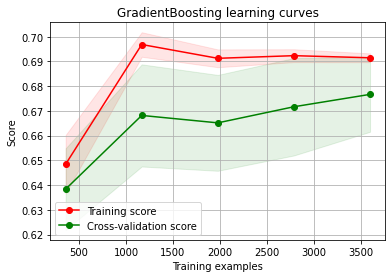

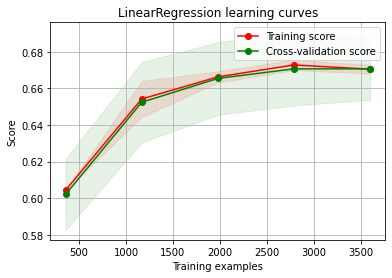

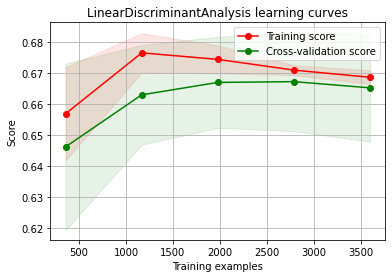

In [61]:
# plot learning curves
plot_learning_curve(gsgbc.best_estimator_,"GradientBoosting learning curves",x_train,y_train,cv=kfold)
plot_learning_curve(lrc.best_estimator_,"LinearRegression learning curves",x_train,y_train,cv=kfold)
plot_learning_curve(ldac.best_estimator_,"LinearDiscriminantAnalysis learning curves",x_train,y_train,cv=kfold)

Text(0.5, 1.0, 'Linear discriminant analysis feature importance')

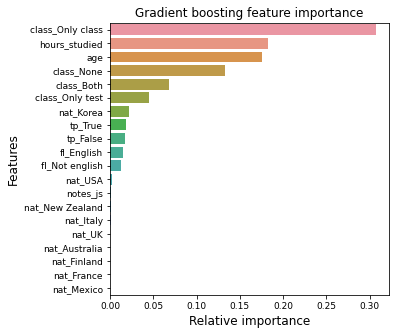

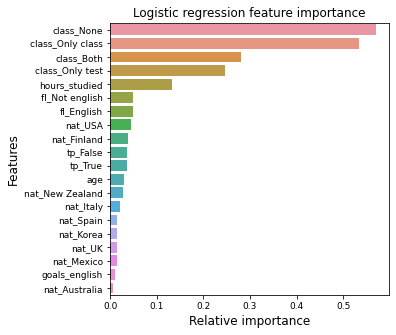

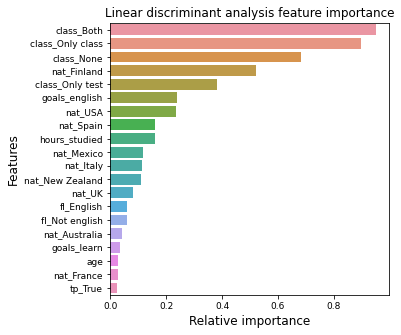

In [62]:
# gradient boosting
fig, axes = plt.subplots(figsize=(5,5))
ind = np.argsort(gbc_best.feature_importances_)[::-1][:20]
fig = sns.barplot(y = x_train.columns[ind][:20],
                x = gbc_best.feature_importances_[ind][:20] , 
                orient='h')
fig.set_xlabel("Relative importance",fontsize=12)
fig.set_ylabel("Features",fontsize=12)
fig.tick_params(labelsize=9)
fig.set_title('Gradient boosting feature importance')

# logistic regression
fig, axes = plt.subplots(figsize=(5,5))
coefs = np.abs(lrc_best.coef_[0])
ind = np.argsort(coefs)[::-1][:20]
fig = sns.barplot(y = x_train.columns[ind][:20],
                x = coefs[ind[:20]], 
                orient='h')
fig.set_xlabel("Relative importance",fontsize=12)
fig.set_ylabel("Features",fontsize=12)
fig.tick_params(labelsize=9)
fig.set_title('Logistic regression feature importance')

# linear discriminant analysis
fig, axes = plt.subplots(figsize=(5,5))
coefs = np.abs(ldac_best.coef_[0])
ind = np.argsort(coefs)[::-1][:20]
fig = sns.barplot(y = x_train.columns[ind][:20],
                x = coefs[ind[:20]], 
                orient='h')
fig.set_xlabel("Relative importance",fontsize=12)
fig.set_ylabel("Features",fontsize=12)
fig.tick_params(labelsize=9)
fig.set_title('Linear discriminant analysis feature importance')

GBC: 0.633
LRC: 0.637
LDAC: 0.635


<AxesSubplot:>

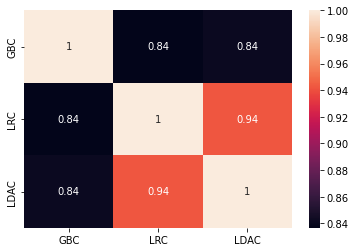

In [63]:
test_pass_gbc = pd.Series(gbc_best.predict(test), name="GBC")
test_pass_gbc.index = test_ind
print('GBC: ' + str(accuracy_score(y_valid,test_pass_gbc)))
test_pass_lrc = pd.Series(lrc_best.predict(test), name="LRC")
test_pass_lrc.index = test_ind
print('LRC: ' + str(accuracy_score(y_valid,test_pass_lrc)))
test_pass_ldac = pd.Series(ldac_best.predict(test), name="LDAC")
test_pass_ldac.index = test_ind
print('LDAC: ' + str(accuracy_score(y_valid,test_pass_ldac)))

ens_results = pd.concat([test_pass_gbc, test_pass_lrc, test_pass_ldac], axis = 1)
sns.heatmap(ens_results.corr(),annot=True)

In [64]:
# ensemble modeling
votingC = VotingClassifier(estimators=[('gbc', gbc_best), ('lrc', lrc_best),
('ldac', ldac_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(x_train, y_train)

In [65]:
# prediction
results = pd.Series(votingC.predict(test), name="Passed")
results.index = test_ind

accuracy_score(y_valid,results)

0.639

In [66]:
results.to_csv("results_voting.csv")